<a href='#1'>1. Data's Overview</a>

<a href='#2'>2. Preprocessing</a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import datetime # manipulating date formats
import gc

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        


/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


# <a id='1'>1. Data's Overview</a>

## Loading data

In [2]:
building_metadata = pd.read_csv('/kaggle/input/ashrae-energy-prediction/building_metadata.csv')
train = pd.read_csv('/kaggle/input/ashrae-energy-prediction/train.csv', parse_dates=['timestamp'])
test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/test.csv', parse_dates=['timestamp'])
weather_train = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_train.csv', parse_dates=['timestamp'])
weather_test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_test.csv', parse_dates=['timestamp'])

In [3]:
#Function to reduction memory usage (Source code from Kaggle)
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

Check missing data

In [4]:
def missing(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percentage = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])
    return missing_data.head(data.shape[1])

In [5]:
missing(weather_train)

,Total,Percentage
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
site_id,0,0.000000
timestamp,0,0.000000


In [6]:
missing(weather_test)

,Total,Percentage
cloud_coverage,140448,50.658808
precip_depth_1_hr,95588,34.478057
sea_level_pressure,21265,7.670167
wind_direction,12370,4.461790
wind_speed,460,0.165919
dew_temperature,327,0.117947
air_temperature,104,0.037512
site_id,0,0.000000
timestamp,0,0.000000


In [7]:
missing(building_metadata)

,Total,Percentage
floor_count,1094,75.500345
year_built,774,53.416149
site_id,0,0.000000
building_id,0,0.000000
primary_use,0,0.000000
square_feet,0,0.000000


# <a id='2'>2. Preprocessing</a>

## a. Missing data

### Air_temperature

There are only 55 missing values in the weather_train data set.

We fill the missing data with the value from the closest previous day without na, at the same time of the day, of the same site (there's no NA from the same hour in two consecutive days of the same site)

In [8]:
import math
def fill_air_temp(data):
    
    '''Function for filling Na data in air_temperature variable'''
    
    na_index = data[data['air_temperature'].isnull()].index
    temp_key = ['site_id', 'timestamp', 'air_temperature']
    
    for i in na_index:
        site_na = data.loc[i, 'site_id']   
        for j in range(5):
            time_na = data.loc[i,'timestamp'] - datetime.timedelta(days = j+1)  
            ind = data[(data.site_id == site_na) & (data.timestamp == time_na)].index  
            
            if math.isnan(data.loc[ind, 'air_temperature']) == False :
                data.loc[i, 'air_temperature'] = data.loc[ind, 'air_temperature'].values
                break
    
    return data

In [9]:
weather_train = fill_air_temp(weather_train)
weather_test = fill_air_temp(weather_test)

### floor_count and year_built

In [10]:
#According to the above table, 53.41% of year_built and 75.50% of floor_count are not available

#We fill the floor_count's NA by mode = 1 (repsent 7.52% of floor_count values) and the year_built by the mean of it value
building_metadata.fillna({'floor_count':1,'year_built': building_metadata['year_built'].mean()}, inplace = True)

### Other variables

In [11]:
#Even the weather data don't change more in the futur and the past, so we make a forward and backward filling
# First: transformation of the timestamp into a datetime object 
# Second: sorting by site id then timestamp

weather_train = weather_train.sort_values(by=['site_id', 'timestamp']) 
weather_train.fillna(method = 'bfill', inplace=True, limit = 12) #backfill up to 12 hours
weather_train.fillna(method = 'ffill', inplace = True, limit = 12) #forward fill the missing data up to 12 hours


## Weather test
weather_test = weather_test.sort_values(by=['site_id', 'timestamp']) 
weather_test.fillna(method = 'bfill', inplace=True, limit = 12)
weather_test.fillna(method = 'ffill', inplace=True, limit = 12)

<AxesSubplot:>

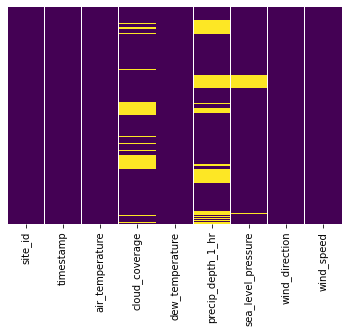

In [12]:
sns.heatmap(weather_train.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
sns.heatmap(weather_test.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [13]:
#Train data
missing_cols = [col for col in weather_train.columns if weather_train[col].isna().any()] 
fill_lib = weather_train.groupby('site_id')[missing_cols].transform('mean')
#stores the mean of each feature for each site id
weather_train.fillna(fill_lib, inplace=True) #for each feature with missing 
#values, fill the missing entry with the mean for that site

#Test data
missing_cols = [col for col in weather_test.columns if weather_test[col].isna().any()] 
fill_lib = weather_test.groupby('site_id')[missing_cols].transform('mean')
#stores the mean of each feature for each site id
weather_test.fillna(fill_lib, inplace=True)
del missing_cols, fill_lib

weather_train.isna().sum()
#weather_test.isna().sum()

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

## b. Align the timestamp

The timestamps of the weather data and the train/test data are different: those in the weather data is not in the site's local time. So there's need an alignment before merging these dataset by timestamps.

To see this problem, we plot the air temperature (from weather data) and energy consumption (from train data) by site and hour.
We assume that highest air temperature should appear at around 14:00.

In [14]:
def plot_by_site_by_hour(data, column) :
    '''Plot a variable by site and hour'''
    
    plot_key = ['site_id', 'timestamp']
    col_to_plot = data[plot_key + [column]].copy()
    col_to_plot['hour'] = col_to_plot['timestamp'].dt.hour
    
    c = 1
    plt.figure(figsize=(25, 15))
    for site_id, data_by_site in col_to_plot.groupby('site_id'):
        by_site_by_hour = data_by_site.groupby('hour').mean()
        ax = plt.subplot(4, 4, c)
        plt.plot(by_site_by_hour.index,by_site_by_hour[column],'xb-')
        ax.set_title('site: '+str(site_id))
        c += 1
    return plt.show()

In [15]:
weather = pd.concat([weather_train,weather_test],ignore_index=True)

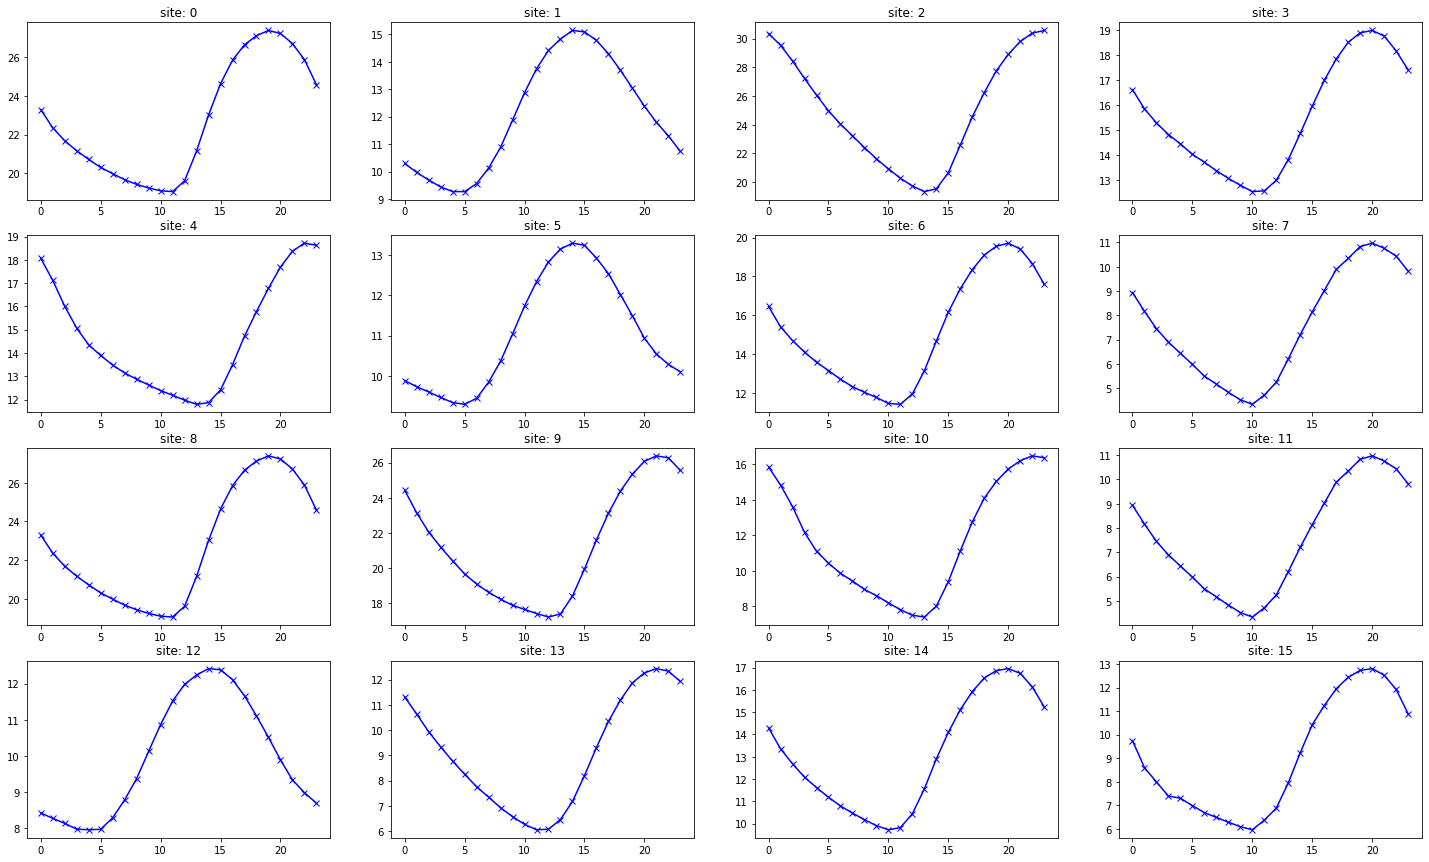

In [16]:
plot_by_site_by_hour(weather,'air_temperature')

We see that the peak temperature for most of these site are not around 14:00, some even at night, which doesn't make sense.

In [17]:
#Create dataframe having site_id and meter from train and metadata datasets
building_site_dict = dict(zip(building_metadata['building_id'], building_metadata['site_id']))
site_meter = train[['building_id', 'meter', 'timestamp', 'meter_reading']].copy()
site_meter['site_id'] = site_meter.building_id.map(building_site_dict)
del site_meter['building_id']

#Dataframe with site_id and electrical consumption
site_elec = site_meter[site_meter.meter == 0]

In [18]:
#plot_by_site_by_hour(site_elec, 'meter_reading')
del building_site_dict, site_meter, site_elec
gc.collect()

38709

The energy consumption of these sites make sense, which mean that the timestamps are more aligned.

In [19]:
# calculate ranks of hourly temperatures within date and site_id
key = ['site_id', 'timestamp', 'air_temperature']
temp = weather.loc[:,key]
temp['temp_rank'] = temp.groupby(['site_id', temp.timestamp.dt.date])['air_temperature'].rank('average')

# site_id x mean hour rank of temperature within day
mean_rank = temp.groupby(['site_id', temp.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

In [20]:
#the timestamp alignment gap for each site
gap = pd.Series(mean_rank.values.argmax(axis=1) - 14)
gap.index.name = 'site_id'

def timestamp_align(data):
    '''Function to align the timestamp'''
    data['offset'] = data.site_id.map(gap)
    data['timestamp_aligned'] = (data.timestamp - pd.to_timedelta(data.offset, unit='H'))
    data['timestamp'] = data['timestamp_aligned']
    del data['timestamp_aligned']
    return data

In [21]:
weather_train = timestamp_align(weather_train)
weather_test = timestamp_align(weather_test)
del weather, temp, gap
gc.collect()

57

In [22]:
del weather_train['offset'], weather_test['offset']

## c. Merge data

In [23]:
train_merge = train.merge(building_metadata, on='building_id', how='left', validate='many_to_one')
train_merge = train_merge.merge(weather_train, on=['site_id', 'timestamp'], how='left', validate='many_to_one')
del train, weather_train

test_merge = test.merge(building_metadata, on='building_id', how='left', validate='many_to_one')
test_merge = test_merge.merge(weather_test, on=['site_id', 'timestamp'], how='left', validate='many_to_one')
del test, weather_test, building_metadata

This additionnal missing values appear here because some merging identity (timesamp) of train and test dataset aren't in  weather data. 

In [24]:
#train_data
train_merge = train_merge.sort_values(by=['building_id', 'timestamp'])
train_merge.fillna(method = 'ffill', inplace=True)

#test data
test_merge = test_merge.sort_values(by=['building_id', 'timestamp'])
test_merge.fillna(method = 'ffill', inplace=True)

In [25]:
train_merge = reduce_mem_usage(train_merge)
test_merge = reduce_mem_usage(test_merge)

Memory usage after optimization is: 1041.10 MB
Decreased by 60.3%
Memory usage after optimization is: 2147.36 MB
Decreased by 60.3%


In [26]:
train_merge.loc[(train_merge.meter == 0) & (train_merge.site_id == 0) , 'meter_reading'] = train_merge.loc[(train_merge.meter == 0) & (train_merge.site_id == 0) , 'meter_reading'] * 0.2931

# EDA

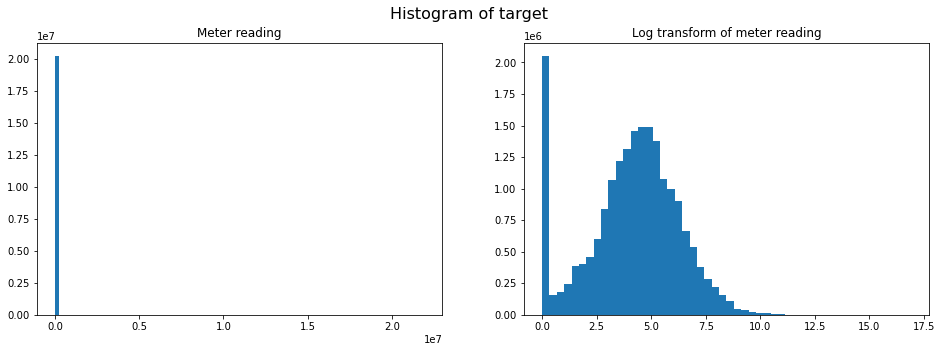

In [27]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.hist(train_merge.meter_reading, bins = 100)
plt.title('Meter reading')
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train_merge.meter_reading), bins = 50)
plt.title('Log transform of meter reading')
plt.suptitle('Histogram of target', fontsize = 16)
plt.show()

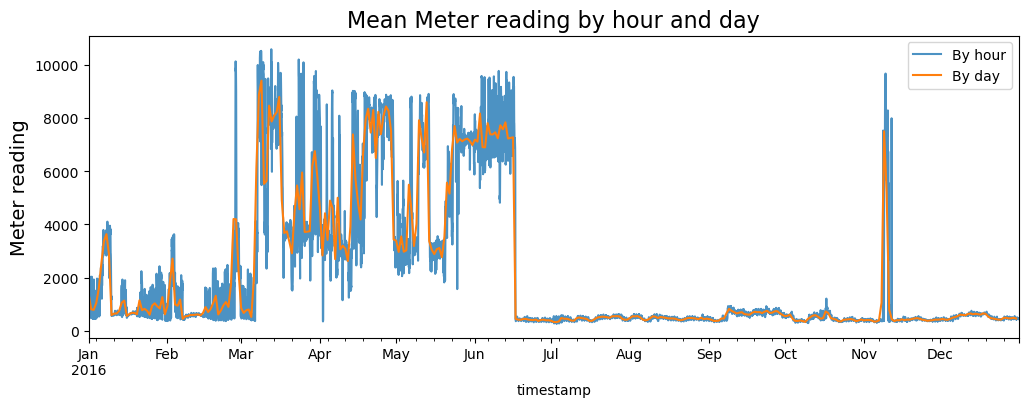

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
train_merge[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train_merge[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day', fontsize=16);
axes.legend();

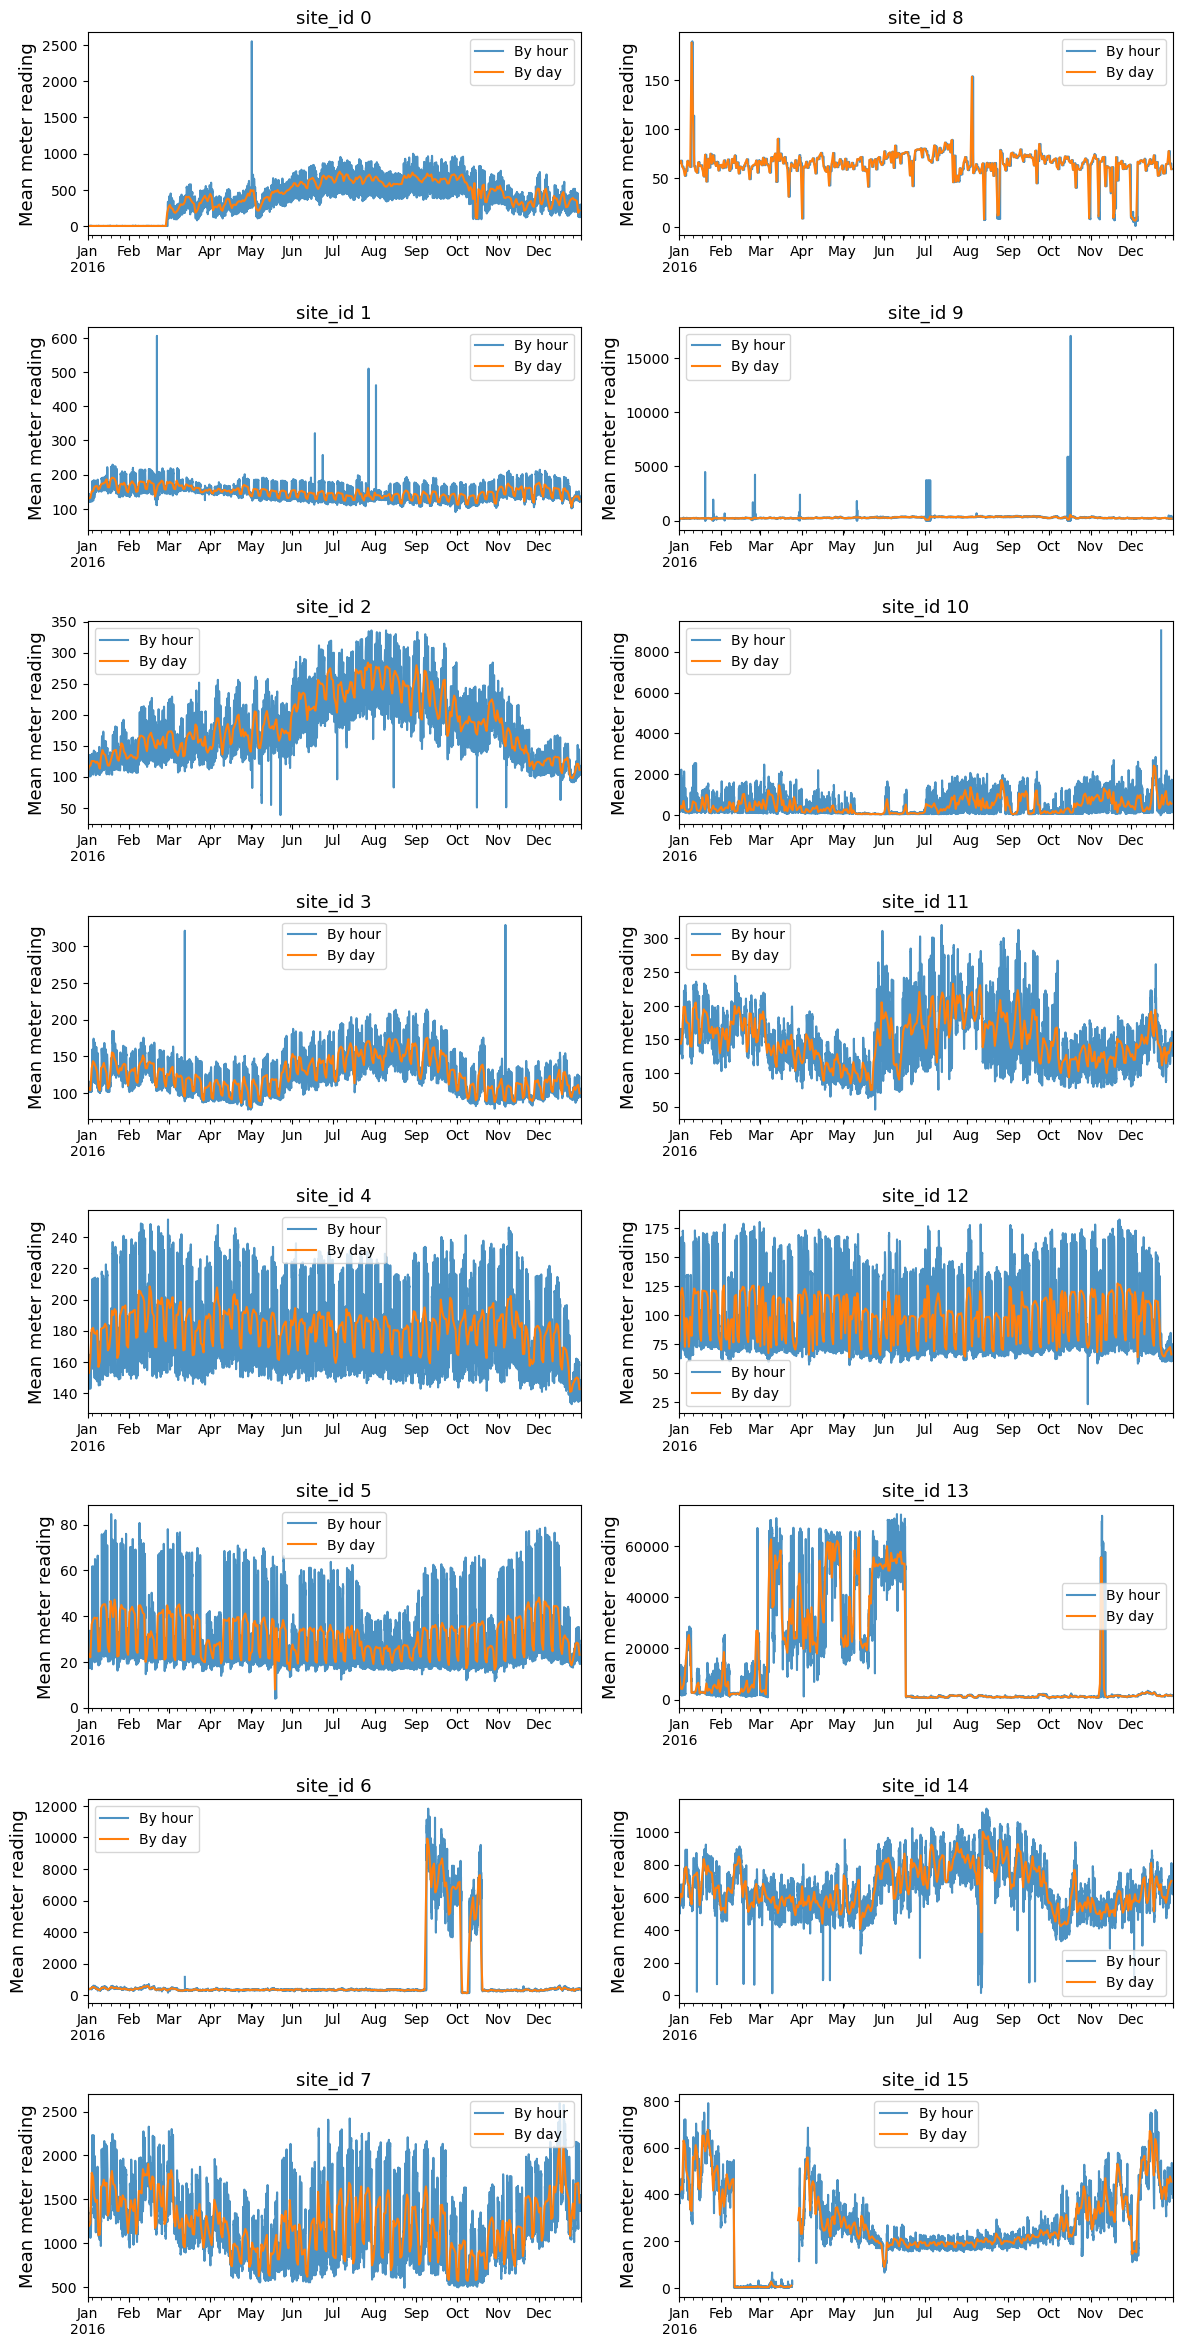

In [29]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(train_merge['site_id'].nunique()):
    train_merge[train_merge['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train_merge[train_merge['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

Something is wrong with side_id 1, the first 3 months of 2016, the consumption there is almost 0.

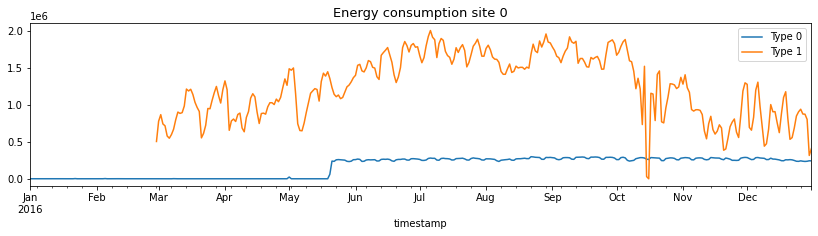

In [30]:
plt.figure(figsize=(14,3))
for t in [0, 1]:
    tmp_df = train_merge[(train_merge.site_id == 0) & (train_merge.meter == t) ].copy()
    tmp_df.set_index("timestamp", inplace=True)
    tmp_df.resample("D").meter_reading.sum().plot(label = f"Type {t}")
plt.legend()
plt.title('Energy consumption site 0', fontsize=13)
plt.show()

There is not energy consumption type 0 before around 20/05, we should remove these observations.

In [31]:
train_merge.groupby("building_id").meter_reading.sum().sort_values(ascending=False)[:5]

building_id
1099    3.350620e+10
778     4.404115e+08
1168    4.286342e+08
1197    3.904003e+08
1159    3.142415e+08
Name: meter_reading, dtype: float32

Site 13 has same the same partern consumption as the over all the data. And we see the building 1099 has the largest consumption, it is also belong to site 13.

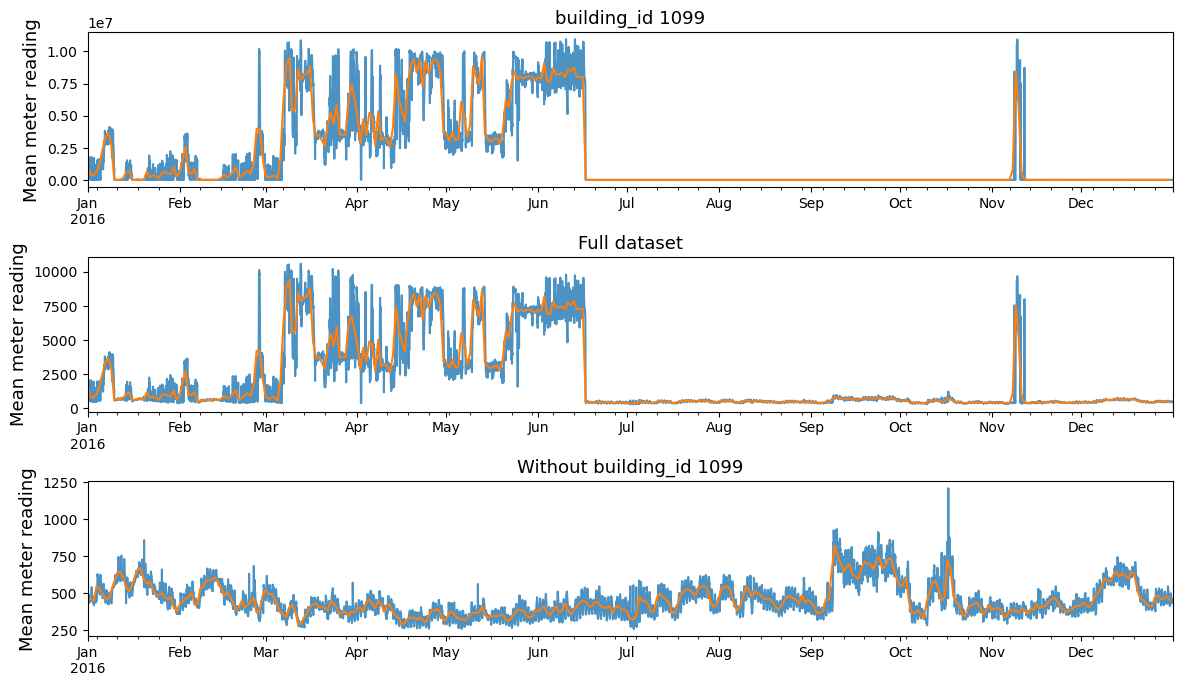

In [32]:
fig, axes = plt.subplots(3,1,figsize=(14,8), dpi=100)

train_merge[(train_merge['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[0], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train_merge[(train_merge['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[0], alpha=1, label='By day', color='tab:orange').set_xlabel('');

train_merge[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[1], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train_merge[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[1], alpha=1, label='By day', color='tab:orange').set_xlabel('');

train_merge[~(train_merge['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[2], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train_merge[~(train_merge['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[2], alpha=1, label='By day', color='tab:orange').set_xlabel('');

axes[0].set_title('building_id 1099', fontsize=13);
axes[1].set_title('Full dataset', fontsize=13);
axes[2].set_title('Without building_id 1099', fontsize=13);
plt.subplots_adjust(hspace=0.45)

We see that the building 1099 with very large consumption has significant impact on over all the data. We can consider those observations as outliers and should remove them for better prediction.

In [33]:
train_merge = train_merge [ train_merge['building_id'] != 1099 ]
train_merge = train_merge.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

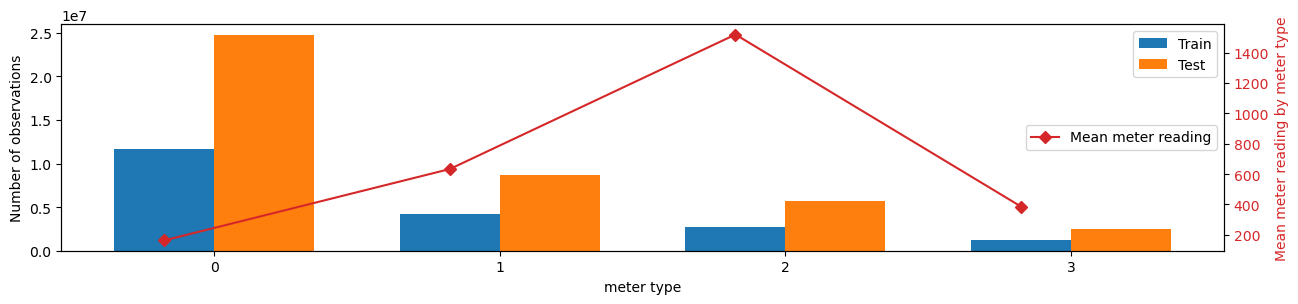

In [34]:
train_data = train_merge['meter'].value_counts(dropna=False).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(15, 3), dpi=100)
tr = axes.bar(ind, train_data, width)

test_data = test_merge['meter'].value_counts(dropna=False).sort_index().values
tt = axes.bar(ind+width, test_data, width)

axes.set_ylabel('Number of observations');
axes.set_xlabel('meter type');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train_merge['meter'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train_merge[['meter', 'meter_reading']].groupby('meter')['meter_reading'].mean().sort_index().values, 'D-', color='tab:red', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:red');
axes2.set_ylabel('Mean meter reading by meter type', color='tab:red');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

# BUILDING

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

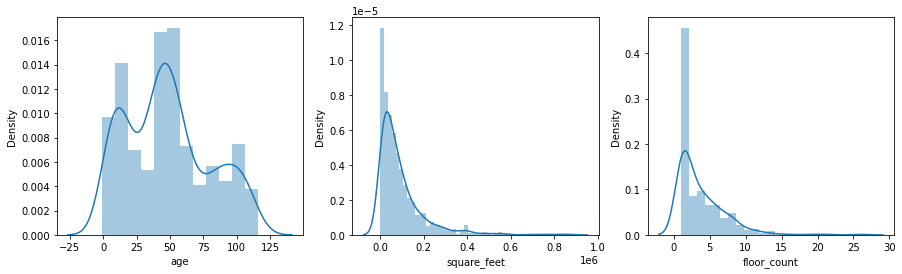

In [35]:
buildings = pd.read_csv('/kaggle/input/ashrae-energy-prediction/building_metadata.csv')
buildings['age'] = 2016 - buildings['year_built']
plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
sns.distplot(buildings.age.dropna());
plt.subplot(1, 3, 2)
sns.distplot(buildings.square_feet.dropna());
plt.subplot(1, 3, 3)
sns.distplot(buildings.floor_count.dropna());

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


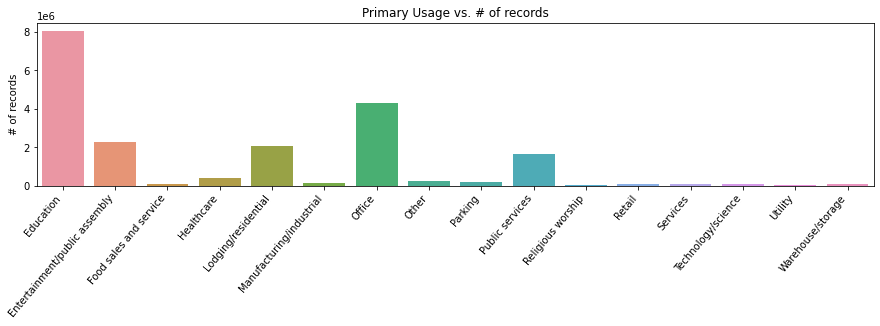

In [36]:
plt.figure(figsize=(15,3))
ax = sns.barplot(buildings.groupby(['primary_use']).size().reset_index(name='counts')['primary_use'], train_merge.groupby(['primary_use']).size().reset_index(name='counts')['counts'])
ax.set(xlabel='', ylabel='# of records', title='Primary Usage vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


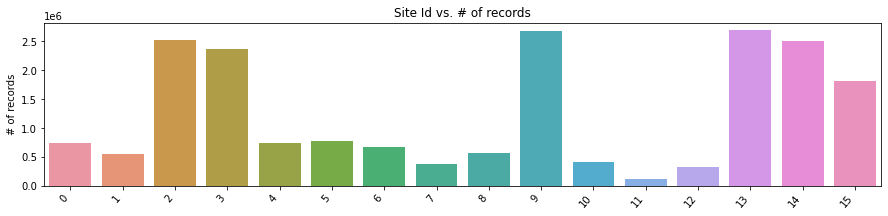

In [37]:
plt.figure(figsize=(15,3))
ax = sns.barplot(buildings.groupby(['site_id']).size().reset_index(name='counts')['site_id'], train_merge.groupby(['site_id']).size().reset_index(name='counts')['counts'])
ax.set(xlabel='', ylabel='# of records', title='Site Id vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

In [38]:
weather_train = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_train.csv', parse_dates=['timestamp'])
weather_test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_test.csv', parse_dates=['timestamp'])

In [39]:
def plot_dist_col(column):
    '''plot dist curves for train and test weather data for the given column name'''
    sns.distplot(weather_train[column].dropna())
    sns.distplot(weather_test[column].dropna())
    plt.xlabel(column, fontsize=15)
    plt.legend(['train', 'test'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

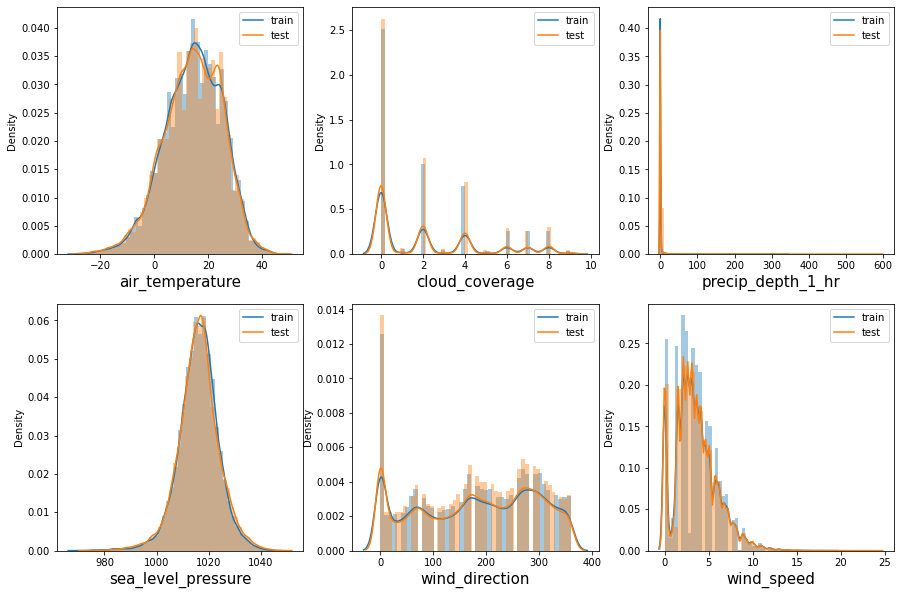

In [40]:
plt.figure(figsize=(15,10))
plt.subplot(2, 3, 1)
plot_dist_col('air_temperature')
plt.subplot(2, 3, 2)
plot_dist_col('cloud_coverage')
plt.subplot(2, 3, 3)
plot_dist_col('precip_depth_1_hr')
plt.subplot(2, 3, 4)
plot_dist_col('sea_level_pressure')
plt.subplot(2, 3, 5)
plot_dist_col('wind_direction')
plt.subplot(2, 3, 6)
plot_dist_col('wind_speed')

# FE

In [41]:
def degToCompass(num):
    val=int((num/22.5)+.5)
    arr=[i for i in range(0,16)]
    return arr[(val % 16)]

def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekday"] = df["timestamp"].dt.weekday
    df['month'] = df['timestamp'].dt.month.astype(np.int8)
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
    df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
    
    df['square_feet'] =  np.log1p(df['square_feet'])
    #df['sm'] = df['site_id'].apply(lambda x: str(x)) + '_' + df['meter'].apply(lambda x: str(x))
    df['wind_direction'] = df['wind_direction'].apply(degToCompass)
    
    beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]
    for item in beaufort:
        df.loc[(df['wind_speed']>=item[1]) & (df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]
    
    # Remove Unused Columns
    drop = ["timestamp","sea_level_pressure", "wind_speed","year_built","floor_count"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    from sklearn import preprocessing
    
    le = preprocessing.LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    # reduce memory
    df = reduce_mem_usage(df)
    
    return df

In [42]:
train_merge = features_engineering(train_merge)
test_merge = features_engineering(test_merge)

Memory usage after optimization is: 643.71 MB
Decreased by 58.0%
Memory usage after optimization is: 1352.04 MB
Decreased by 58.0%


In [43]:
train_merge.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,wind_direction,hour,weekday,month,is_holiday,beaufort_scale
7536835,0,0,0.0,0,0,8.914062,21.703125,2.0,20.59375,0.0,0,1,4,5,0,0.0
7539178,0,0,0.0,0,0,8.914062,21.703125,4.0,20.59375,0.0,0,2,4,5,0,0.0
7541522,0,0,0.0,0,0,8.914062,22.203125,4.0,21.09375,0.0,9,3,4,5,0,2.0
7543869,0,0,0.0,0,0,8.914062,22.203125,4.0,20.59375,0.0,0,4,4,5,0,0.0
7546214,0,0,0.0,0,0,8.914062,21.703125,6.0,20.59375,0.0,9,5,4,5,0,2.0


# Correlation

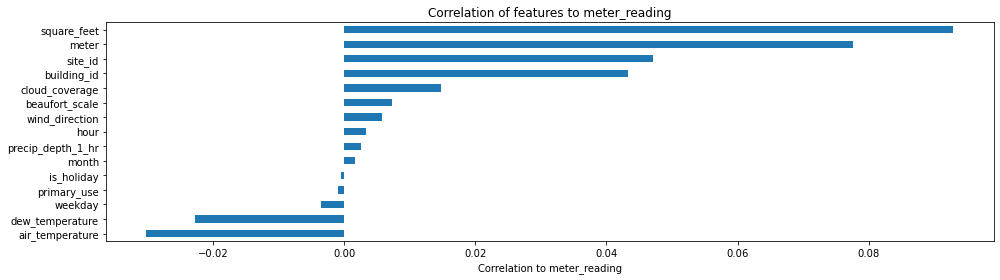

In [46]:
corr = train_merge.corr()
plt.figure(figsize=(14,4));
corr["meter_reading"].sort_values(ascending=True)[:-1].plot(kind="barh")
plt.title("Correlation of features to meter_reading")
plt.xlabel("Correlation to meter_reading")
plt.tight_layout()
plt.show()

<AxesSubplot:>

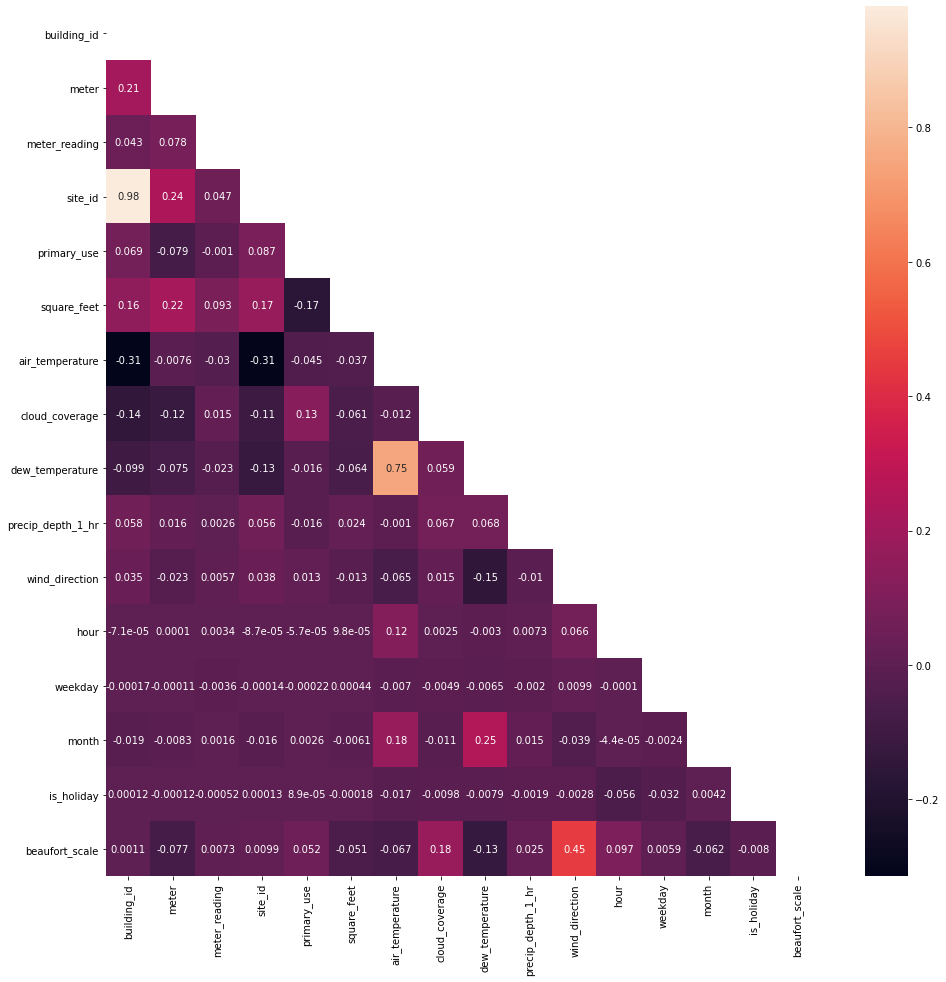

In [51]:
plt.subplots(figsize=(16, 16))
sns.heatmap(corr, annot = True, mask = np.triu(corr))